In [1]:
import pandas as pd 
import numpy as np 

In [4]:
! pip install -q -U bitsandbytes
# ! pip install -q -U git+https://github.com/huggingface/transformers.git
! pip install transformers==4.31
! pip install -q -U git+https://github.com/huggingface/peft.git
! pip install -q -U git+https://github.com/huggingface/accelerate.git
! pip install -q datasets
! pip install evaluate
! pip install -qqq trl==0.7.1

  Using cached transformers-4.31.0-py3-none-any.whl.metadata (116 kB)
  Using cached tokenizers-0.13.3.tar.gz (314 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Using cached transformers-4.31.0-py3-none-any.whl (7.4 MB)
Failed to build tokenizers


  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [49 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-312\tokenizers
      copying py_src\tokenizers\__init__.py -> build\lib.win-amd64-cpython-312\tokenizers
      creating build\lib.win-amd64-cpython-312\tokenizers\models
      copying py_src\tokenizers\models\__init__.py -> build\lib.win-amd64-cpython-312\tokenizers\models
      creating build\lib.win-amd64-cpython-312\tokenizers\decoders
      copying py_src\tokenizers\decoders\__init__.py -> build\lib.win-amd64-cpython-312\tokenizers\decoders
      creating build\lib.win-amd64-cpython-312\tokenizers\normalizers
      copying py_src\tokenizers\normalizers\__init__.py -> build\lib.win-amd64-cpython-312\tokenizers\normalizers
      creating build\lib.win-amd64-cpython-312\tokenizers\pre_tokenizers
      copying py_src

In [1]:
import pandas as pd

In [3]:
df= pd.read_csv("datasets/train_ft.csv")

In [4]:
df.head()

,Case Name,Input,Output,Label,Count,Decision_Count,text
0,"KAMLESH Vs. UNION OF INDIA THROUGH SECRETARY, ...",30.3.92 after noon regular appoint is made. Mi...,0[ds]7. It is clear from the order of appointm...,0,1253,564,### Instruction:\nForecast the likely verdict ...
1,KANWAR PAL SINGH Vs. THE STATE OF UTTAR PRADESH,raised by the appellant in the written submiss...,1[ds]5. We find the submission of the appellan...,1,4065,2268,"### Instruction:\nFirst, predict whether the a..."
2,Manke Ram Vs. State of Haryana,appellant in this case is that even if the pro...,1[ds]6. Having perused the material on record ...,1,1616,708,### Instruction:\nDetermine the likely decisio...
3,Kr. Jyoti Sarup and Another Vs. Board of Reven...,and by the substantive part of sub-section (1)...,"0[ds]7. We are in agreement with the view, exp...",0,2440,784,### Instruction:\nJudge the probable resolutio...
4,"Commissioner Of Income-Tax, Kerala Vs. Gemini ...",the true costs of trading in the particular ye...,1[ds]That case can have no application to the ...,1,3317,722,### Instruction:\nAssess the case to predict t...


In [17]:
df1= pd.read_csv("datasets/train_ft.csv")

In [18]:
df1.shape

(10961, 7)

In [19]:
df4= pd.read_csv("datasets/val_ft.csv")

In [20]:
df4.shape

(1217, 7)

In [21]:
df2.shape

(3044, 6)

In [6]:
df1.head()

,Case Name,Input,Output,Label,Count,Decision_Count
0,"KAMLESH Vs. UNION OF INDIA THROUGH SECRETARY, ...","S. ABDUL NAZEER, J. 1. In this appeal, appella...",0[ds]7. It is clear from the order of appointm...,0,1253,564
1,KANWAR PAL SINGH Vs. THE STATE OF UTTAR PRADESH,"SANJIV KHANNA, J. 1. Leave granted. 2. Kanwar ...",1[ds]5. We find the submission of the appellan...,1,4065,2268
2,Manke Ram Vs. State of Haryana,"Santosh Hegde, J. 1. The incident which gives ...",1[ds]6. Having perused the material on record ...,1,1616,708
3,Kr. Jyoti Sarup and Another Vs. Board of Reven...,"S.K. Das, J. 1. These two appeals and the conn...","0[ds]7. We are in agreement with the view, exp...",0,2440,784
4,"Commissioner Of Income-Tax, Kerala Vs. Gemini ...","Shah, J. 1. Two persons-Walter and Ramasubramo...",1[ds]That case can have no application to the ...,1,3317,722


In [6]:
df2= pd.read_csv("datasets/test.csv")
df2.shape

(3044, 6)

In [5]:
df2["Input"][0]

'Subba Rao, J.1. These two appeals by special leave are filed against the common judgment of a Full Bench of the High Court of Judicature at Nagpur in writ petitions Nos. 22 of 1955 and 274 of 1955 filed by respondents 1, 3 to 6 herein in the said Court.2. The facts in Appeal No. 370 of 1960 may be stated first. Respondent 1, Seth Balkishan Nathani, was the proprietor and lambardar of Mouza Sonpairi in Tehsil and District Raipur. On January 14, 1947, he executed perpetual pastas in favour of his wife, Yashodabai, since deceased, and respondents 4, 5 and 6 in respect of khudkasht and grass lands of Mouza Sonpairi. In Tabdili Jamabandi of the year 1941347 the said lands were recorded as the Occupancy Tenancy Holdings of the said respondent 4 to 6 and respondent 2, Govindlal Nathani, the legal representative of Yashodabai. The same entry was found in the Jamabandis of the subsequent years. The Madhya Pradesh Abolition of Proprietary Rights (Estates, Mahals, Alienated Lands) Act, l950 (1 o

In [18]:
df2["Label"][78]

np.int64(1)

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import spacy
import re
from collections import Counter

c:\Users\Ayush\OneDrive\Documents\ml\nlp-proj\legal_pred_env_new\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
# Load models and NLP tools
MODEL_PATH = "saved_models/legal/best_model"
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
nlp = spacy.load("en_core_web_sm")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

def extract_key_points(text):
    """Extract key legal points from the text."""
    doc = nlp(text)
    
    # Extract sentences with legal keywords
    legal_keywords = {
        'jurisdiction', 'provision', 'section', 'act', 'order',
        'appeal', 'review', 'authority', 'court', 'power'
    }
    
    key_sentences = []
    for sent in doc.sents:
        words = set(token.text.lower() for token in sent)
        if any(keyword in words for keyword in legal_keywords):
            key_sentences.append(sent.text)
    
    return key_sentences

def analyze_sections_cited(text):
    """Extract and analyze sections cited in the text."""
    section_pattern = r'(?:Section|S\.)\s*(\d+(?:\(\d+\))?(?:\s*of\s*the\s*[A-Za-z\s]+)?)'
    sections = re.findall(section_pattern, text)
    return Counter(sections)

def generate_explanation(text, prediction, confidence):
    """Generate a detailed explanation for the prediction."""
    key_points = extract_key_points(text)
    sections = analyze_sections_cited(text)
    
    explanation = {
        "decision": "Favorable" if prediction == 1 else "Unfavorable",
        "confidence": f"{confidence:.2%}",
        "key_points": key_points[:3],  # Top 3 key points
        "sections_cited": dict(sections.most_common(3)),  # Top 3 most cited sections
        "reasoning": []
    }
    
    # Add reasoning based on key legal indicators
    if "jurisdiction" in text.lower():
        explanation["reasoning"].append("Jurisdictional aspects were considered")
    if "final" in text.lower():
        explanation["reasoning"].append("Finality of orders was discussed")
    if "power" in text.lower():
        explanation["reasoning"].append("Authority/power considerations were present")
    
    return explanation

def predict_text(text):
    # Tokenize and prepare input
    text= str(text)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(predictions, dim=1).item()
        confidence = predictions[0][predicted_class].item()
    
    # Generate detailed explanation
    explanation = generate_explanation(text, predicted_class, confidence)
    
    return {
        "prediction": predicted_class,
        "prediction_text": explanation["decision"],
        "confidence": confidence,
        "explanation": explanation
    }


c:\Users\Ayush\OneDrive\Documents\ml\nlp-proj\legal_pred_env_new\Lib\site-packages\transformers\modeling_utils.py:460: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

In [25]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_model(dataset_path):
    # Load the dataset
    df = pd.read_csv(dataset_path)
    df= df.head(100)
    
    true_labels = []
    predicted_labels = []
    confidences = []
    
    for _, row in df.iterrows():
        text = row['Input']
        true_label = row['Label']
        
        # Predict
        prediction = predict_text(text)
        predicted_label = prediction["prediction"]
        confidence = prediction["confidence"]
        
        # Store results
        true_labels.append(true_label)
        predicted_labels.append(predicted_label)
        confidences.append(confidence)
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "average_confidence": sum(confidences) / len(confidences)
    }


In [29]:
dataset_path = "datasets/test.csv"
metrics = evaluate_model(dataset_path)
print(f"Metrics on test set: {metrics}")

 Metrics on test set: {'accuracy': 0.64, 'precision': np.float64(0.64), 'recall': np.float64(1.0), 'f1_score': np.float64(0.6111111111111112), 'average_confidence': 0.6196530783176422}


C:\Users\Ayush\AppData\Local\Temp\ipykernel_12072\1829138546.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_names, y=metric_values, palette="viridis")


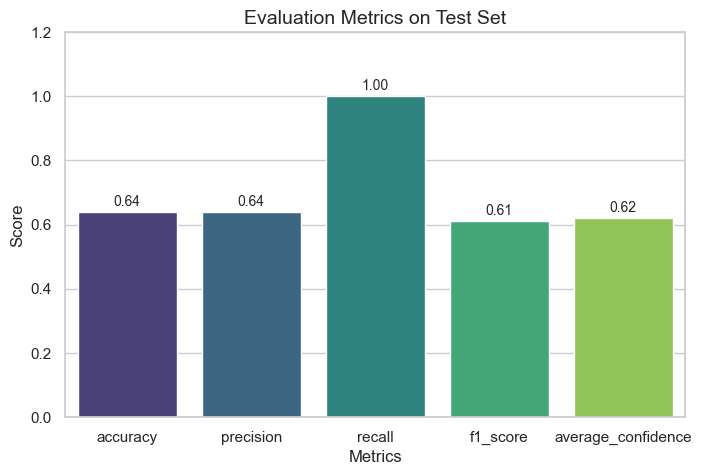

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Metrics data
metrics = {
    'accuracy': 0.64,
    'precision': np.float64(0.64),
    'recall': np.float64(1.0),
    'f1_score': np.float64(0.6111111111111112),
    'average_confidence': 0.6196530783176422
}

# Convert metrics to a format suitable for plotting
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

# Create a bar plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(x=metric_names, y=metric_values, palette="viridis")

# Add values above bars
for i, v in enumerate(metric_values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)

# Customize the plot
plt.title("Evaluation Metrics on Test Set", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Metrics", fontsize=12)
plt.ylim(0, 1.2)  # Adjust y-axis for visibility
plt.show()


C:\Users\Ayush\AppData\Local\Temp\ipykernel_12072\1909109342.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_names, y=metric_values, palette="viridis")


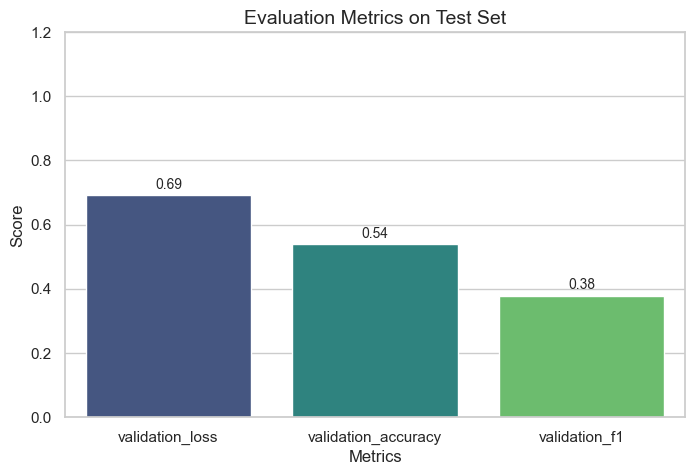

In [3]:
metrics = {
    'validation_loss': 0.6921,
    'validation_accuracy': 0.5400,
    'validation_f1': 0.3787
}

# Convert metrics to a format suitable for plotting
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

# Create a bar plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(x=metric_names, y=metric_values, palette="viridis")

# Add values above bars
for i, v in enumerate(metric_values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)

# Customize the plot
plt.title("Evaluation Metrics on Test Set", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Metrics", fontsize=12)
plt.ylim(0, 1.2)  # Adjust y-axis for visibility
plt.show()

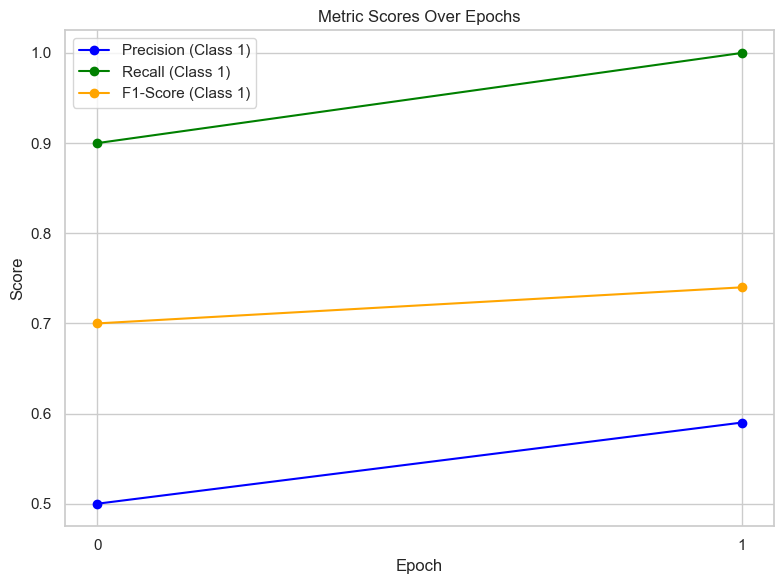

In [5]:
import matplotlib.pyplot as plt

# Example data for epochs
epochs = [0, 1]
precision_class_1 = [0.50, 0.59]  # Change these values based on actual data
recall_class_1 = [0.90, 1.00]  # Example recall values
f1_class_1 = [0.70, 0.74]  # Example F1-score values

# Plotting the line graph
plt.figure(figsize=(8, 6))

# Line for Precision
plt.plot(epochs, precision_class_1, label="Precision (Class 1)", marker='o', color='blue')

# Line for Recall
plt.plot(epochs, recall_class_1, label="Recall (Class 1)", marker='o', color='green')

# Line for F1-Score
plt.plot(epochs, f1_class_1, label="F1-Score (Class 1)", marker='o', color='orange')

# Labels, title, and legend
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Metric Scores Over Epochs")
plt.xticks(epochs)  # Ensures only epochs 0 and 1 are shown
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()
